Upload your ZIP file containing images...


Saving archive (5).zip to archive (5).zip
Extracted images to folder: dataset
Found 500 images.


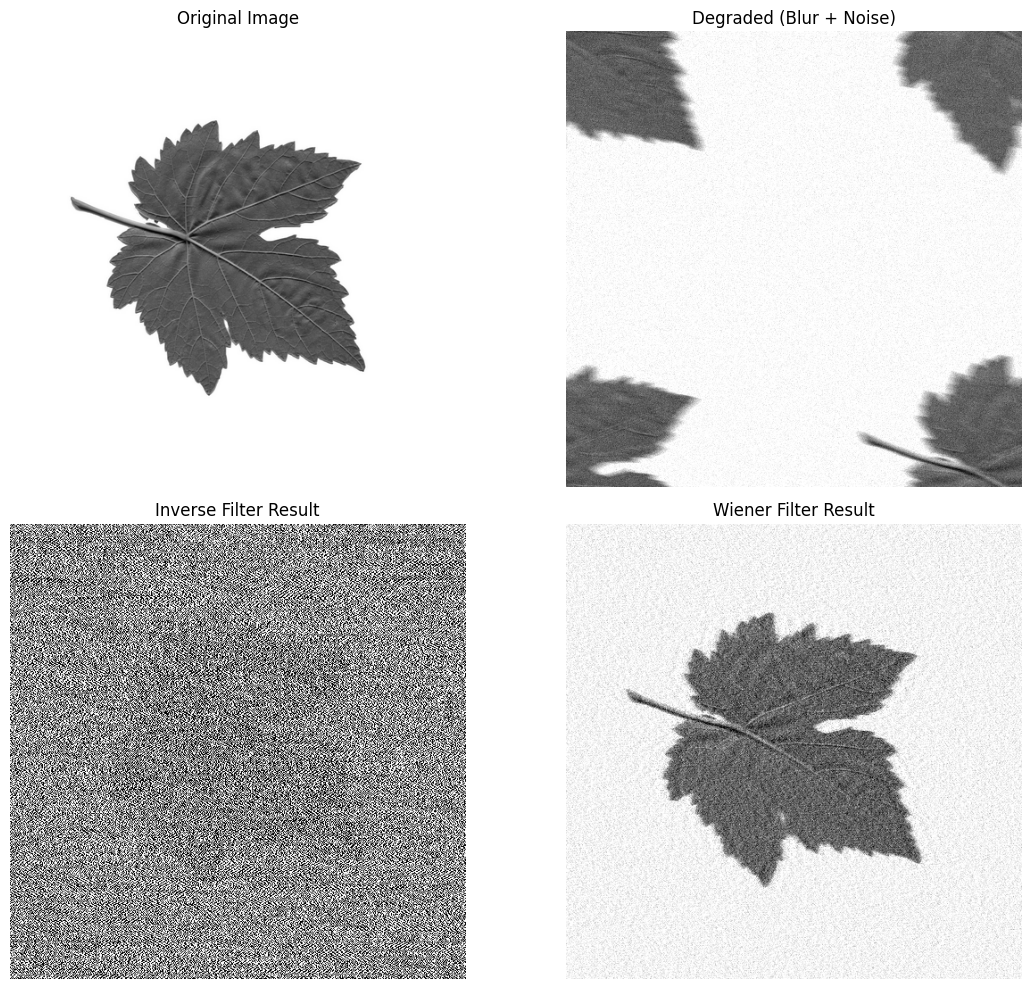

Processing complete!
Degraded images saved in: ./degraded_images
Inverse filter results saved in: ./inverse_restored
Wiener filter results saved in: ./wiener_restored


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import os

# ---------------- Step 1: Upload ZIP Dataset ----------------
print("Upload your ZIP file containing images...")
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

# ---------------- Step 2: Extract ZIP ----------------
extract_folder = "dataset"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Extracted images to folder: {extract_folder}")

# ---------------- Step 3: Recursively find all images ----------------
image_files = []
for root, dirs, files in os.walk(extract_folder):
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, f))

print(f"Found {len(image_files)} images.")
if len(image_files) == 0:
    raise ValueError("No images found in the ZIP. Check file types and folder structure.")

# ---------------- Step 4: Create output folders ----------------
os.makedirs("inverse_restored", exist_ok=True)
os.makedirs("wiener_restored", exist_ok=True)
os.makedirs("degraded_images", exist_ok=True)

# ---------------- Step 5: Utility functions ----------------
def motion_blur_psf(size=21, angle=0):
    psf = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    angle_rad = np.deg2rad(angle)
    sin_a = np.sin(angle_rad)
    cos_a = np.cos(angle_rad)
    for i in range(size):
        x = center + (i - center) * cos_a
        y = center + (i - center) * sin_a
        xi = int(round(x))
        yi = int(round(y))
        if 0 <= xi < size and 0 <= yi < size:
            psf[yi, xi] = 1
    psf /= psf.sum() if psf.sum() != 0 else 1.0
    return psf

def psf_filter_image(img, psf):
    img_f = np.fft.fft2(img)
    psf_padded = np.zeros_like(img, dtype=np.float32)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf
    psf_padded = np.fft.ifftshift(psf_padded)
    H = np.fft.fft2(psf_padded)
    G = H * img_f
    g = np.fft.ifft2(G).real
    return np.clip(g, 0, 255).astype(np.uint8), H

def inverse_filter(degraded, H, eps=1e-3):
    G = np.fft.fft2(degraded)
    H_abs = np.abs(H)
    denom = np.where(H_abs < eps, eps, H)
    F_hat = G / denom
    f_hat = np.fft.ifft2(F_hat).real
    return np.clip(f_hat, 0, 255).astype(np.uint8)

def wiener_filter(degraded, H, K=None):
    G = np.fft.fft2(degraded)
    H_conj = np.conj(H)
    H_abs2 = np.abs(H) ** 2
    if K is None:
        noise_var_est = np.var(degraded.astype(np.float32) - cv2.filter2D(degraded, -1, psf))
        signal_var_est = max(np.var(degraded.astype(np.float32)) - noise_var_est, 1e-8)
        K = noise_var_est / signal_var_est
        if K < 1e-8:
            K = 1e-8
    W = H_conj / (H_abs2 + K)
    F_hat = W * G
    f_hat = np.fft.ifft2(F_hat).real
    return np.clip(f_hat, 0, 255).astype(np.uint8), K

# ---------------- Step 6: Process all images ----------------
psf_size = 15
psf_angle = 10
noise_sigma = 10.0
psf = motion_blur_psf(psf_size, psf_angle)

for idx, img_path in enumerate(image_files):
    img_name = os.path.basename(img_path)
    orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize if too large
    max_side = 512
    h, w = orig.shape
    if max(h, w) > max_side:
        scale = max_side / max(h, w)
        orig = cv2.resize(orig, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

    # Degrade image: motion blur + Gaussian noise
    degraded, H = psf_filter_image(orig.astype(np.float32), psf)
    noise = np.random.normal(0, noise_sigma, degraded.shape)
    degraded = np.clip(degraded.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Apply filters
    inv_restored = inverse_filter(degraded.astype(np.float32), H, eps=1e-3)
    wiener_restored, estK = wiener_filter(degraded.astype(np.float32), H, K=None)

    # Save results
    cv2.imwrite(os.path.join("degraded_images", img_name), degraded)
    cv2.imwrite(os.path.join("inverse_restored", img_name), inv_restored)
    cv2.imwrite(os.path.join("wiener_restored", img_name), wiener_restored)

    # Display only the first image in 2x2 grid
    if idx == 0:
        titles = ["Original Image", "Degraded (Blur + Noise)", "Inverse Filter Result", "Wiener Filter Result"]
        imgs = [orig, degraded, inv_restored, wiener_restored]
        plt.figure(figsize=(12, 10))
        for i, (im, t) in enumerate(zip(imgs, titles), 1):
            ax = plt.subplot(2, 2, i)
            ax.imshow(im, cmap='gray')
            ax.set_title(t, fontsize=12)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Processing complete!")
print("Degraded images saved in: ./degraded_images")
print("Inverse filter results saved in: ./inverse_restored")
print("Wiener filter results saved in: ./wiener_restored")

